In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import homogeneity_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

In [75]:
# Download MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Split into training and testing sets
# NOTE y labels should be IGNORED completely ignored by the algorithms,
# however, we will use them to measure the quality of clustering
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Normalize pixel values to a range [0-1]
X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35000, 784) (35000, 784) (35000,) (35000,)


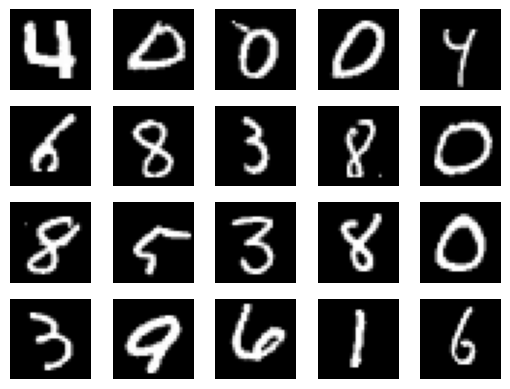

In [76]:
# Plot 20 random images in 4 x 5 grid.
n_samples = 20
# Random images, and no duplicates
random_idx = np.random.choice(X.shape[0], n_samples, replace=False)
for idx in range(n_samples):
    plt.subplot(4, 5, idx + 1)
    plt.imshow(X[random_idx[idx]].reshape(28, 28), cmap='gray')
    plt.axis('off')

In [77]:
# K-Means Clustering Algorithm
algo = KMeans(n_clusters=10, init = 'random', n_init= 'auto')
algo.fit(X_train)
pred = algo.fit_predict(X_test)
original_homogeneity = homogeneity_score(y_test, pred)
print(f'Homogeneity Score: {original_homogeneity:.2f}')

Homogeneity Score: 0.50


Evaluation Of Homogeneity Score: Homogeneity measures how well clusters contain only members of a single class or label. A Homogeneity Score of .50, means that for prediction clusters, only 50% of them actually fit the true labels. Example only 50% of 0's were mapped to the true 0 class.

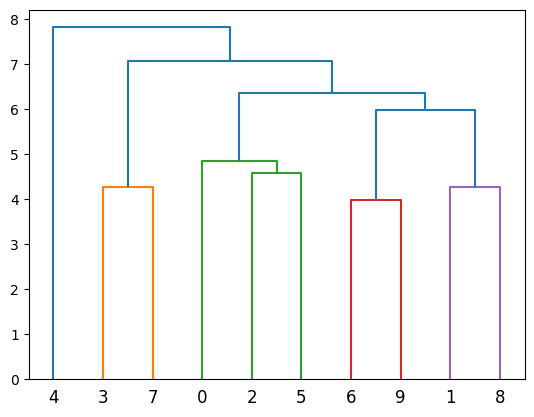

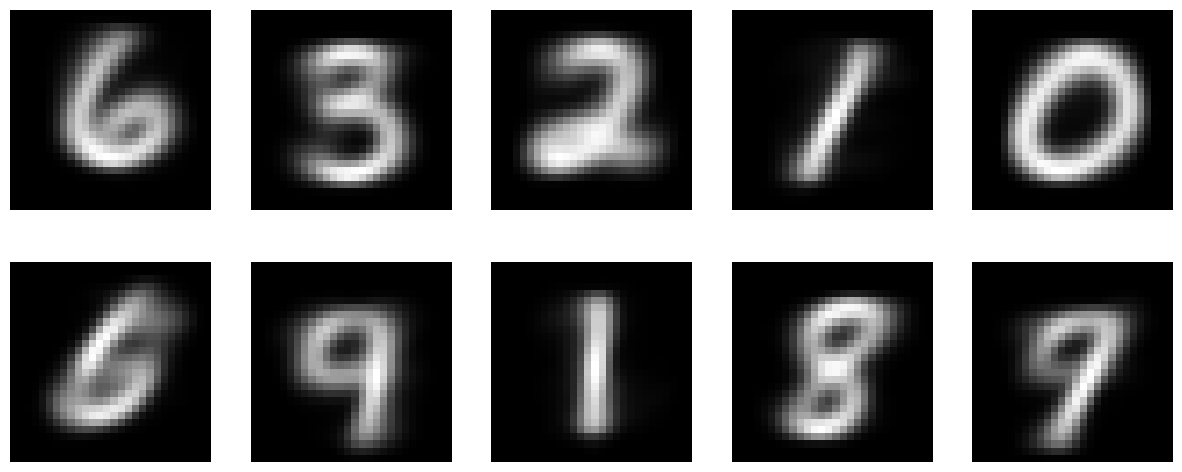

In [84]:
# Hierachical Agglomerative Clustering

#Obtain centroids from K-Means
centroids = algo.cluster_centers_
#Setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric = 'euclidean')
model.fit(centroids)

#Plot dendrogram
linkage_matrix = linkage(centroids, method='ward')
dendrogram(linkage_matrix)
plt.show()

#Plot Centroids as images
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroids[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

How Images Relate To Dendrogram: In these 10 images, we see a pair each of 6, 9, and 1. This indicates a lack of diversity in the sample, and that there is redundant clusters (K-Mean wasn't able to differentiate effectively). In the dendrogram, 6 and 9 have a merger (possibly due to curved shape), and so does 1 and 8 (possibly due to vertical shape), indicating a similarity of features between these digits, especially when considering these mergers have relatively low heights (this relates to the redundancy in the images). 7 out of 10 digits are represented however which is still a reasonable spread across the dataset.

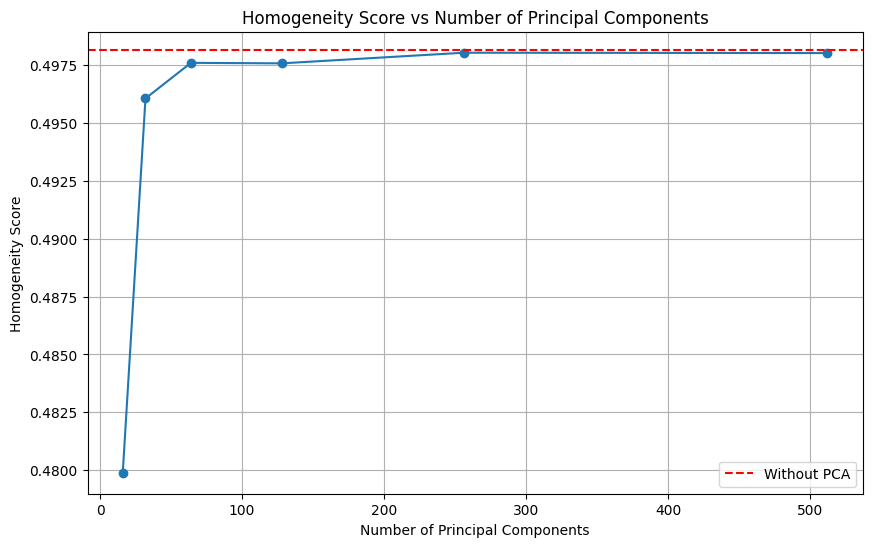

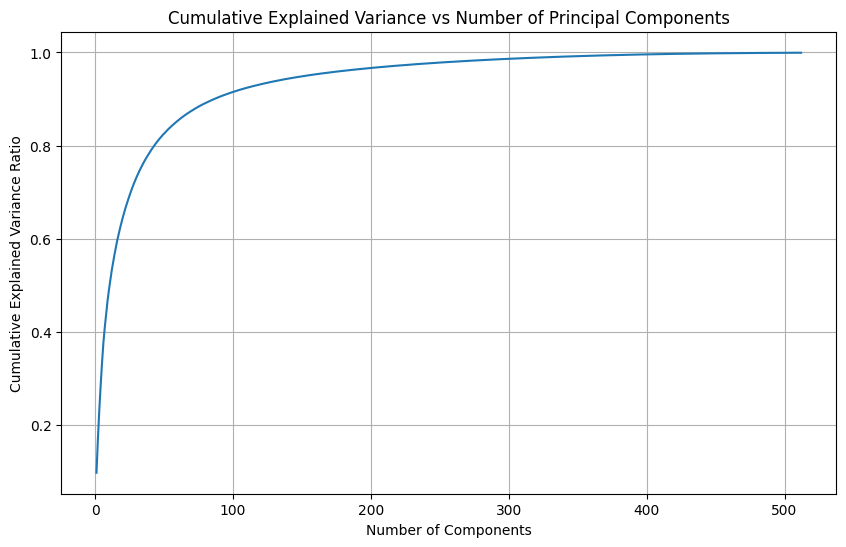

Homogeneity Scores:
Components: 16, Score: 0.4799
Components: 32, Score: 0.4961
Components: 64, Score: 0.4976
Components: 128, Score: 0.4976
Components: 256, Score: 0.4980
Components: 512, Score: 0.4980
Original (without PCA): 0.4982


In [102]:
#PCA 
pca = PCA()
pca.fit(X_train)

#Sorted eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_


#List of components
component_list = [16, 32, 64, 128, 256, 512]
homogeneity_scores = []

for n_component in component_list:
    pca = PCA(n_components=n_component)
    X_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    #K-Means
    algo = KMeans(n_clusters=10, init = 'random', n_init= 'auto')
    algo.fit(X_pca)
    pred = algo.fit_predict(X_test_pca)  

    #Homogeneity scores
    homogeneity = homogeneity_score(y_test, pred)
    homogeneity_scores.append(homogeneity) 

#Original
algo = KMeans(n_clusters=10, init = 'random', n_init= 'auto')
algo.fit(X_train)
pred = algo.fit_predict(X_test)
original_homogeneity = homogeneity_score(y_test, pred)


#Credit to Claude for helping generate these plots
#Plot: Number of principal components vs Clustering performance
plt.figure(figsize=(10, 6))
plt.plot(component_list, homogeneity_scores, marker='o')
plt.axhline(y=original_homogeneity, color='r', linestyle='--', label='Without PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Homogeneity Score')
plt.title('Homogeneity Score vs Number of Principal Components')
plt.legend()
plt.grid(True)
plt.show()

#Plot: Cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.grid(True)
plt.show()

#Print results
print("Homogeneity Scores:")
for n_components, score in zip(component_list, homogeneity_scores):
    print(f"Components: {n_components}, Score: {score:.4f}")
print(f"Original (without PCA): {original_homogeneity:.4f}")

Analysis Of Plots: In the first plot, we can see that PCA honestly didn't have much impact on the performance (homogeneity score), when rounded, all the values from 32 to 512 components result in a homogeneity score roughly ~0.50, which is what the original homogeneity without PCA was. The second plot shows a steep increase in cumulative explained variance from 16 to 64 components, and continued increase (although less dramatic)  to 256 components, after which we see a plateau. This trend is reflected when analyzing the first plot, and it's printed values in combination, we see that with 16 components in PCA we had the worst performance but incremental improvement up to 64 components, and from 64 components to 512 we see almost negligible increases in performance.